In [1]:
using LinearAlgebra
using Plots
using LaTeXStrings

# Quantum Dots transfer
In this notebook, we study a simple model of transfer between two quantum dots (QDs) connected by a chiral molecule (in the rest of this notebook it'll be considered as a single DNA strand).

## Definition of the model

### Hamiltonian
The tight-binding Hamiltonian we consider is a first-order discretized version of the continuous Hamiltonian introduced in [Vittmann et al., 2022](https://pubs.acs.org/doi/10.1021/acs.jpclett.1c03975).

The Helix Hamiltonian is

$\hat{H}_\text{helix} = - t_h \sum_{n=1}^{N}\sum_{\sigma=\{\uparrow,\downarrow\}} \left( \hat{c}^{\dagger}_{n+1, \sigma}\hat{c}_{n, \sigma} + \text{h.c.} \right) + \epsilon_h \sum_{n,\sigma} \hat{c}^{\dagger}_{n, \sigma}\hat{c}_{n, \sigma} + \hat{H}_{SOC} + U_h\hat{\mathbb{1}}$

with the hopping energy $t_h = \frac{\hbar^2}{2m_h l^2}$ and the on-site energy $\epsilon_h = \frac{\hbar^2}{m_h l^2}$, $l$ is the distance between two DNA nucleobases, and $U_h$ a fixed (for now) background energy.

Using the first-order discretization of $\partial_s$ the spin-orbit coupling (SOC) is given by

$\hat{H}_{SOC} = -\mathrm{i}\frac{\alpha_N}{2l} \sum_n \left(\hat{\sigma}_{B_{n,n+1}}\left(\sum_{\sigma} \hat{c}^\dagger_{n, \sigma}\hat{c}_{n+1, \sigma} - \text{h.c.}\right) - \hat{\sigma}_{N_{n,n+1}} \frac{\tau}{2}\right)$

It can be checked by direct calculation in the single excitation subspace (defined below) that the SOC Hamiltionian introduced in [Guo and Sun, 2012](https://link.aps.org/doi/10.1103/PhysRevLett.108.218102)

$\mathcal{H}_{so} = \sum_{n}\mathrm{i}t_{so}c^\dagger_{n}\left[\sigma_\perp((n-1)\Delta\varphi) + \sigma_\perp(n\Delta\varphi)\right]c_{n+1} + \text{h.c.}$

is equal to the first order discretized version of $-\mathrm{i}\alpha_N\hat{\sigma}_B\partial_s$.

The quantum dots are described as two-level systems with energies $\varepsilon_{L/R}$ (independently of the spin orientation) and are coupled to the nearest nucleobase with a hopping energy $t_{L/R}$

$\hat{H}_{L/R} = \sum_\sigma \varepsilon_{L/R}\hat{d}^\dagger_{L/R, \sigma}\hat{d}_{L/R, \sigma} - t_{L/R}\left(\hat{d}^\dagger_{L/R, \sigma}\hat{c}_{1/N, \sigma} + \text{h.c.}\right)$

### Single Excitation Subspace
Given that the Hamiltonian we consider conserves the number of excitations, we can work in the single excitation subspace (SES).

This has two advantages:
* The size of the Hilbert space is decreased from $(N + 2)^2$ to $2(N+2)$
* We don't need to bother too much with the Fermionic  canonical anti-commutation relations

Thus, the states we consider are $|\uparrow, 0, 0, \dots, 0\rangle, |0, \uparrow, 0, \dots, 0\rangle, \ldots, |0, 0, \ldots, 0, \uparrow\rangle, |\downarrow, 0, 0, \dots, 0\rangle, |0, \downarrow, 0, \dots, 0\rangle, \ldots, |0, 0, \ldots, 0, \downarrow\rangle$.

Hence, every operator in this notebook is going to be defined in the full $2(N+2)$-dimensional SES.

## Model parameters
The following units are used:
- eV for energies
- nm for distances
- fs for time

### Helix Geometric parameters

In [3]:
N = 10 # Number of nucleobases

l = 0.34 # nm distance between two nucleobases (found on wikipedia)

s = [i*l for i=0:N-1]; # nm Position of the nucleobases

R =  0.7 # nm Radius

P = 3.4/(2*pi) # nm Pitch

D_square = R^2 + P^2

D = sqrt(D_square)

cosbeta = R/D

sinbeta = P/D

τ = P/D_square # torsion nm^{-1}

κ = R/D_square # curvature nm^{-1}

0.8942050420728438

### Physical parameters

In [4]:
ħ = 0.658 # reduced Planck constant in eV.fs

## SOC strength ##
αN = 0.008 # eV.nm (it's actually hbar*alpha here)

αB = 0

## Masses ##
m = 5.68 # eV.fs^{2}.nm^{-2} electron mass in free space

mh = 10*m # effective elctron mass in the helix

th = 0.5*ħ^2/(mh*l^2) # eV hopping energy

ϵh = ħ^2/(mh*l^2) # eV on-site energy

# Fixed background helix potential
Uh = 0.9I # eV

UniformScaling{Float64}
0.9*I

### QDs parameters

In [5]:
ϵL = 1 # eV

ϵR = 1 # eV

tL = th

tR = tL

0.03296974755105024

### Parameters for the ODE solver

In [6]:
t0 = 0.0    # initial time in fs

tf = 400  # final time in fs

dt = 0.01  # time step in fs

t_eval = t0:dt:tf  # recorded time shots

0.0:0.01:400.0

## Definition of operators

All the operators (e.g. $\hat{c}^\dagger_{n+1,\sigma}\hat{c}_{n,\sigma}$, $\hat{\sigma}_{N_{n,n+1}}\ldots$) are going to be defined directly in the full SES.

In [14]:
diagonal = zeros(N+2)
lower_diagonal = ones(N+1)
cd_nplus1_c_n_one_spin = Bidiagonal(diagonal, lower_diagonal, :L)

12×12 Bidiagonal{Float64,Array{Float64,1}}:
 0.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
 1.0  0.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0  0.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0  0.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   1.0  0.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅   1.0  0.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅   1.0  0.0   ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0  0.0   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0  0.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0  0.0   ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0  0.0   ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0  0.0

In [19]:
cd_nplus1_c_n = zeros(ComplexF64, 2(N+2), 2(N+2))
cd_nplus1_c_n[1:N+2, 1:N+2] = cd_nplus1_c_n_one_spin
cd_nplus1_c_n[N+3:end, N+3:end] = cd_nplus1_c_n_one_spin
cd_nplus1_c_n[N+3,N+2] = 0; # No hopping between (R up), i.e. site N+2, and (L down), i.e. "site" N+3, states

In [20]:
cd_n_c_nplus1 = cd_nplus1_c_n';

In [21]:
cd_n_c_n = I; # In the SES, the number operator reduces to the identity

In [22]:
σT = zeros(ComplexF64, 2(N+2), 2(N+2))
σN = zeros(ComplexF64, 2(N+2), 2(N+2))
σB = zeros(ComplexF64, 2(N+2), 2(N+2))
for i=1:N
    σT[i+1,i+1] = sinbeta
    σT[N+1+i, N+1+i] = -sinbeta
    σT[N+1+i, i+1] = im*exp(im*s[i]/D)*cosbeta
    σT[1+i, N+1+i] = -im*exp(-im*s[i]/D)*cosbeta

    σN[N+1+i, i+1] = -exp(im*s[i]/D)
    σN[1+i, N+1+i] = -exp(-im*s[i]/D)

    σB[i+1,i+1] = cosbeta
    σB[N+1+i, N+1+i] = -cosbeta
    σB[N+1+i, i+1] = -im*exp(im*s[i]/D)*sinbeta
    σB[1+i, N+1+i] = im*exp(-im*s[i]/D)*sinbeta
end

In [24]:
H = zeros(ComplexF64, 2(N+2), 2(N+2))
H += -th*(cd_nplus1_c_n + cd_nplus1_c_n')
H += +ϵh*cd_n_c_n
SOC = -im*0.5*αN/l*(σB*(cd_n_c_nplus1 - cd_nplus1_c_n) - 0.5*τ*σN)
SOC = 0.5*(SOC + SOC')
H += SOC
H += Uh;

In [26]:
H[1,1] = H[N+3,N+3] = ϵL
H[N+2,N+2] = H[end,end] = ϵR
H[1,2] = H[2,1] = H[N+3, N+4] = H[N+4, N+3] = -tL
H[N+1,N+2] = H[N+2,N+1] = H[end, end-1] = H[end-1, end] = -tR;

## Initial state

In [29]:
ψ0 = zeros(ComplexF64, 2(N+2));

ψ0[1] = 1; # Intially the Left Quantum dot is in the up state

ψ = zeros(ComplexF64, length(t_eval), length(ψ0));

ψ[1,:] = ψ0;

### Time Evolution

In [30]:
@doc raw"""
	time_evolve_4th_order(H, psi, dt::Float64=0.05)

Compute \psi(t+dt) given a Hamiltonian H, a wavefunction \psi(t), and a timestep dt using a 4th order approximation of the time evolution operator

```math
U(t+dt, t) \approx \mathbb{1} -\frac{\mathrm{i} dt}{\hbar} H - \frac{dt^2}{2\hbar^2} H^2 + \frac{\mathrm{i} dt^3}{3! \hbar^3} H^3 - \frac{dt^4}{4! \hbar^4}H^4
```

# Arguments
- `H`: the total Hamiltonian, 2(N+2)x2(N+2)-dimensional array.
- `psi`: the wavefunction at time t, 2(N+2)-dimensional array.
- `dt::Float64=0.05`: the evolution timestep.

# Return
- time-evolved wavefunction, 2(N+2)-dimensional array.
"""
function time_evolve_4th_order(H, psi, dt::Float64=0.05)

    k1 = -im/ħ * H*(psi)* dt
    k2 = -im/ħ * H*(k1) * dt / 2
    k3 = -im/ħ * H*(k2) * dt / 3
    k4 = -im/ħ * H*(k3) * dt / 4

    return psi + k1 + k2 + k3 + k4
end


time_evolve_4th_order

In [31]:
for t=2:length(t_eval)
	ψ[t,:] = time_evolve_4th_order(H, ψ[t-1,:], dt)
end

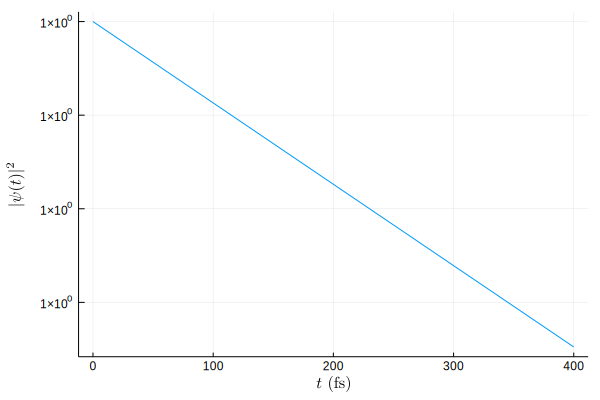

In [32]:
plot(t_eval, sum(abs.(ψ).^2, dims=2), xlabel=L"t\ (\mathrm{fs})", ylabel=L"|\psi(t)|^2", label=:none) # Checking convergence

In [33]:
begin# Definition of the x-axis labels
	sites = ["L"]
	for i=1:N
		sites = push!(sites, "$(i)")
	end
	push!(sites, "R")
end; 

┌ Info: Saved animation to 
│   fn = /home/thibaut/Documents/CISS/code/tmp.gif
└ @ Plots /home/thibaut/.julia/packages/Plots/cc8wh/src/animation.jl:98


Plots.AnimatedGif("/home/thibaut/Documents/CISS/code/tmp.gif")
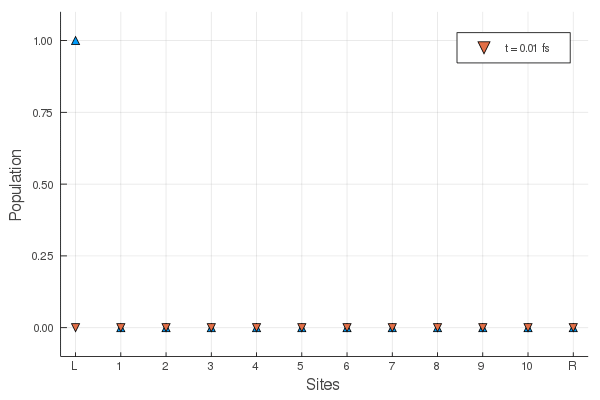

In [36]:
begin
	scatter_plot0 = scatter(sites, abs.(ψ0[1:N+2]).^2, markershape=:utriangle, label=:none, ylims=(-0.1,1.1))
	scatter_plot0 = scatter!(sites, abs.(ψ0[N+3:end]).^2, markershape=:dtriangle, label="t = 0 fs", ylims=(-0.1,1.1), xlabel="Sites", ylabel="Population")
	@gif for t=2:length(t_eval)
		scatter_plot0 = scatter(sites, abs.(ψ[t,1:N+2]).^2,markershape=:utriangle, label=:none, ylims=(-0.1,1.1))
		scatter_plot0 = scatter!(sites, abs.(ψ[t,N+3:end]).^2,markershape=:dtriangle, label="t = $(t_eval[t]) fs", ylims=(-0.1,1.1), xlabel="Sites", ylabel="Population")
	end every 50
end